In [1]:
import os, sys
import matplotlib.pyplot as plt

from timeit import timeit

# import numpy as np
import jax
import jax.numpy as np
from jax import grad, jit

from classy import Class
from pybird.correlator import Correlator

dev mode, reload the following: 

In [2]:
import importlib, pybird
importlib.reload(pybird.correlator)
from pybird.correlator import Correlator

### Linear cosmology

In [3]:
z = .5

In [4]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': z})
M.compute()

In [5]:
kk = np.logspace(-5, 1, 300)
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) 

from scipy.interpolate import interp1d
ipk_lin = interp1d(kk, pk_lin, kind='cubic')

D1, f1 = M.scale_independent_growth_factor(z), M.scale_independent_growth_factor_f(z), 
A_s, Omega0_m = 1e-10 * np.exp(cosmo['ln10^{10}A_s']), M.Omega0_m()

cosmo_lin = {'kk': kk, 'pk_lin': pk_lin, 'f': f1, } # 'D': D1, 'z': z, 'Omega0_m': Omega0_m}

### Just FFTLog, for now

In [6]:
from pybird.fftlog import FFTLog

In [7]:
fftsettings = dict(Nmax=256, xmin=1e-5, xmax=1e3, bias=-0.01, window=0.2)
fft = FFTLog(**fftsettings)

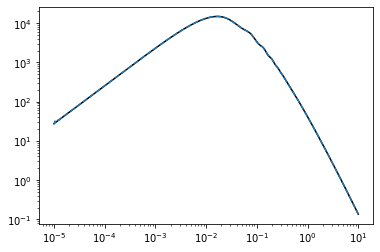

In [8]:
pk_rec = fft.sumCoefxPow(kk, pk_lin, kk) 

plt.plot(kk, pk_lin, 'k')
# plt.plot(kk, pk_rec_0, '--')
plt.plot(kk, pk_rec, '--')

plt.xscale('log')
plt.yscale('log')
plt.show()

In [31]:
jit_Coef = jit(fft.Coef)
init = jit_Coef(kk, pk_lin)

In [32]:
def time_Coef(): fft.Coef(kk, pk_lin)
def time_jit_Coef(): jit_Coef(kk, pk_lin)

In [33]:
print ('%.3f sec' % timeit(stmt=time_Coef, number=100))

1.245 sec


In [34]:
print ('%.3f sec' % timeit(stmt=time_jit_Coef, number=100))

0.039 sec


### PyBird benchmark

Loading some fiducial EFT parameters for testing

In [7]:
outdir = os.path.join(os.path.expanduser('~'), 'share', 'pybird', 'data', 'eftboss', 'out')
with open(os.path.join(outdir, 'fit_boss_onesky_pk_wc_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_params = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}
print (eft_params)

{'b1': 1.9536, 'c2': 0.5865, 'c4': 0.0, 'b3': -0.3595, 'cct': 0.1821, 'cr1': -0.8417, 'cr2': -0.808, 'ce0': 1.4954, 'ce1': 0.0, 'ce2': -1.6292, 'b2': 0.4147, 'b4': 0.4147}


Setting PyBird correlator class in normal mode for benchmark

In [8]:
import importlib, pybird
importlib.reload(pybird.correlator)
from pybird.correlator import Correlator

In [9]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 2, 'kmax': 0.3, 
       'with_resum': False, # 'with_bias': True, 
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 
       'eft_basis': 'eftoflss', 'with_stoch': True}) 

# cosmo_lin.update({'bias': eft_params})

internal PyBird k array on which the predictions is computed (as we do not specify option `'xdata'`)

In [10]:
k0 = N.co.k

Computation in normal mode for benchmark

In [11]:
N.compute(cosmo_lin) 
bpk_0 = N.get(eft_params)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function Coef at /cluster/work/senatore/pybird/pybird/fftlog.py:79 for jit. This concrete value was not available in Python because it depends on the value of the argument 'xin'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:
# N.nonlinear.PsCf(N.bird)

In [ ]:
plt.figure(figsize=(7,2))
for i in range(2): plt.plot(k0, k0 * bpk_0[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

In [18]:
def CoefWindow(N, window=1, left=True, right=True):
    """ FFTLog auxiliary function: window sending the FFT coefficients to 0 at the edges. Adapted from fast-pt """
    n = np.arange(-N // 2, N // 2 + 1)
    if window == 1:
        n_cut = N // 2
    else:
        n_cut = int(window * N // 2.)

    n_right = n[-1] - n_cut
    n_left = n[0] + n_cut

    n_r = n[n[:] > n_right]
    n_l = n[n[:] < n_left]

    theta_right = (n[-1] - n_r) / float(n[-1] - n_right - 1)
    theta_left = (n_l - n[0]) / float(n_left - n[0] - 1)
    
    # W = ones(n.size)
    # if right: W[n[:] > n_right] = theta_right - 1 / (2. * pi) * sin(2 * pi * theta_right)
    # if left: W[n[:] < n_left] = theta_left - 1 / (2. * pi) * sin(2 * pi * theta_left)
    
    W = np.ones(n.size - theta_right.size - theta_left.size)
    if left and not np.isnan(theta_left).any(): W = np.concatenate((theta_left - 1 / (2. * np.pi) * np.sin(2 * np.pi * theta_left), W))
    if right and not np.isnan(theta_right).any(): W = np.concatenate((W, theta_right - 1 / (2. * np.pi) * np.sin(2 * np.pi * theta_right)))
    
    return W
    

0.0


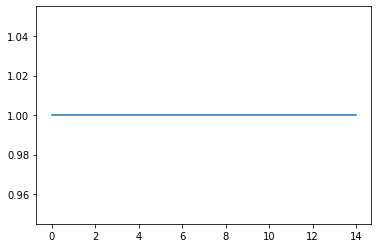

In [15]:
plt.plot( CoefWindow(16, 0.2) )

In [16]:
CoefWindow(16, 0.2)

0.0


DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],            dtype=float32)

In [17]:
len (CoefWindow(16, 0.2))

0.0


15